<a href="https://colab.research.google.com/github/YakshRathod/NULLCLASS-Internship/blob/Task-3/Task_3_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive/Nullclass internship/Task 3
!git clone https://github.com/huggingface/diffusers.git
%cd diffusers
!pip install -e .  # This will install the most recent source version


In [ ]:
import os
import json

# Folder containing your subset images (must match class/image.jpg paths from meta files)
subset_root = '/content/drive/MyDrive/Nullclass internship/Task 3/food-101-limited'

# Path to your meta folder files
meta_root = '/content/drive/MyDrive/Nullclass internship/Task 3/meta'  # adjust this path!

with open(os.path.join(meta_root, 'classes.txt')) as f:
    classes = [line.strip() for line in f.readlines()]

image_set = set()
for cls in classes:
    class_folder = os.path.join(subset_root, cls)
    if os.path.exists(class_folder):
        for fname in os.listdir(class_folder):
            if fname.endswith('.jpg'):
                image_set.add(f"{cls}/{fname}")

# Optionally, use train.txt or your full subset image list
metadata = []
for img_path in sorted(image_set):
    cls = img_path.split('/')[0]
    caption = f"A photo of {cls.replace('_', ' ')}"
    metadata.append({"file_name": img_path, "text": caption})

with open(os.path.join(subset_root, 'metadata.jsonl'), 'w') as f:
    for entry in metadata:
        f.write(json.dumps(entry) + '\n')

print(f"metadata.jsonl written with {len(metadata)} entries")


In [ ]:
import os
from PIL import Image

# Set this to your dataset root directory
dataset_root = '/content/food-101-limited'  # change if needed

broken_images = []
checked, total = 0, 0

for root, dirs, files in os.walk(dataset_root):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            total += 1
            path = os.path.join(root, file)
            try:
                img = Image.open(path)
                img.verify()  # Will not load the whole image, just sanity check
            except Exception as e:
                broken_images.append(path)
            checked += 1
            if checked % 1000 == 0:
                print(f"Checked {checked} images...")

print(f"\nChecked {checked} images out of {total}.")

if broken_images:
    print(f"Found {len(broken_images)} corrupted images! Deleting them...")
    for f in broken_images:
        print(f"Deleting: {f}")
        try:
            os.remove(f)
        except Exception as e_del:
            print(f"Could not delete {f}: {e_del}")
    print("All corrupted images removed.")
else:
    print("No corrupted images found!")


In [ ]:


!cp -rn "/content/drive/MyDrive/Nullclass internship/Task 3/food-101-limited" /content/

!python examples/text_to_image/train_text_to_image_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --train_data_dir="/content/food-101-limited" \
  --resolution=256 \
  --train_batch_size=12 \
  --dataloader_num_workers=2 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=800 \
  --checkpointing_steps=100 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --output_dir="/content/drive/MyDrive/Nullclass internship/Task 3/food101-lora-sd" \
  --report_to="tensorboard" \
  --caption_column="text" \
  --resume_from_checkpoint="latest"




Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/50 [00:00<?, ?it/s]

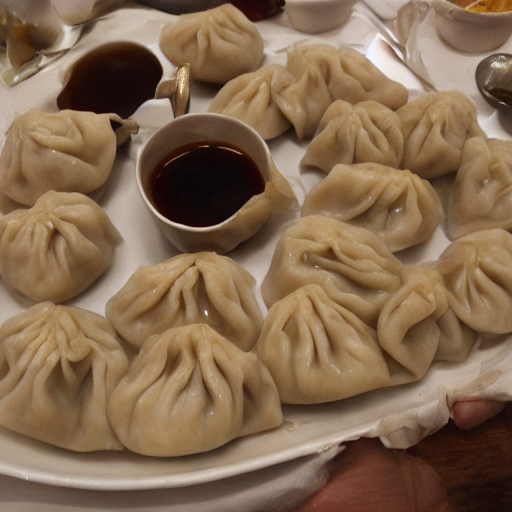

In [ ]:
from diffusers import StableDiffusionPipeline
import torch

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    use_safetensors=True
).to("cuda")

pipe.load_lora_weights("/content/drive/MyDrive/Nullclass internship/Task 3/food101-lora-sd")

prompt = "A photo of dumplings"
image = pipe(prompt).images[0]
image.save("generated.png")

from IPython.display import display
display(image)

